In [1]:
import os
import numpy as np
import pandas as pd
import sys
import json

import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from venny4py.venny4py import *
import math

# Add rpy2
%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(ComplexHeatmap)
    library(cowplot)
    library(facefuns)
    library(factoextra)
    library(FactoMineR)
    library(ggh4x)
    library(ggraph)
    library(ggpubr)
    library(ggrain)
    library(ggridges)
    library(ggseg)
    library(ggsegDesterieux)
    library(ggsignif)
    library(glue)
    library(igraph)
    library(LaCroixColoR)
    library(patchwork)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
    library(VennDiagram) 
})


# Set cowplot theme
theme_set(theme_cowplot())

In addition: Warning message:
package ‘broom’ was built under R version 4.3.3 


In [3]:
# Load classification res
classification_res_path = "/Users/abry4213/data/Cogitate_MEG_challenge/derivatives/classification_results"

stimulus_type_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_stimulus_types_classification_results.csv")
relevance_type_classification_res = pd.read_csv(f"{classification_res_path}/comparing_between_relevance_types_classification_results.csv")

# Add meta_ROI_pair column
stimulus_type_classification_res["meta_ROI_pair"] = stimulus_type_classification_res.meta_ROI_from + "_" + stimulus_type_classification_res.meta_ROI_to
relevance_type_classification_res["meta_ROI_pair"] = relevance_type_classification_res.meta_ROI_from + "_" + relevance_type_classification_res.meta_ROI_to

# SPI directionality info
SPI_directionality_info = pd.read_csv("/Users/abry4213/github/Cogitate_Connectivity_2024/feature_extraction/pyspi_SPI_info.csv")

# Read in meta-ROI data from .json
with open("/Users/abry4213/github/Cogitate_Connectivity_2024/hypothesis_driven_ROIs.json") as f:
    meta_ROI_dict = json.load(f)
# Prepare a list of tuples
rows = []
for key, values in meta_ROI_dict.items():
    for value in values:
        rows.append((key, value))
# Convert list of tuples to DataFrame
meta_ROI_df = (pd.DataFrame(rows, columns=['meta_ROI', 'region'])
               .assign(region = lambda x: x.region.str.replace("_", " ")))


In [4]:
# Define data paths
pyspi_res_path = "/Users/abry4213/data/Cogitate_MEG_challenge/derivatives/time_series_features"
classification_res_path = "/Users/abry4213/data/Cogitate_MEG_challenge/derivatives/classification_results"

SPI_directionality_info = pd.read_csv("/Users/abry4213/github/Cogitate_Connectivity_2024/feature_extraction/pyspi_SPI_info.csv")

# Load in pyspi results
all_pyspi_res_list = []
for pyspi_res_file in os.listdir(pyspi_res_path):
    pyspi_res = pd.read_csv(f"{pyspi_res_path}/{pyspi_res_file}")
    all_pyspi_res_list.append(pyspi_res)
all_pyspi_res = pd.concat(all_pyspi_res_list)

## What is the spatial layout of the three meta-ROIs in the brain?

In [9]:
%%R -i meta_ROI_df

meta_ROI_df_to_plot <- meta_ROI_df %>% 
  rowwise() %>%
  mutate(meta_ROI = str_split(meta_ROI, "_ROIs")[[1]][1])

ggseg(atlas = desterieux, 
      mapping = aes(fill = meta_ROI), .data=meta_ROI_df_to_plot,
      color = "gray30", position = "stacked") +
  theme_void() +
  labs(title="Cogitate Challenge Regions", fill="Meta-ROI") +
  scale_fill_manual(values = c("Category_Selective" = "#DB582D",
                               "GNWT" = "#479D72",
                               "IIT" = "#346DB0"),
                    na.value = 'white') +
  theme(legend.position = "bottom")
# ggsave('plots/Cogitate_Meta_ROIs.svg', width=5, height=3, units='in', dpi=300)

merging atlas and data by 'region'


In [ ]:
stimulus_type_classification_res_cleaned_list = []

for SPI in stimulus_type_classification_res.SPI.unique():

    # Load SPI data
    this_SPI_data = stimulus_type_classification_res.query("SPI==@SPI")

    # Look up directionality
    this_SPI_directionality = SPI_directionality_info.query(f"SPI == '{SPI}'").Directionality.values[0]

    # Merge meta ROIs according to directionality
    if this_SPI_directionality == "Directed":
        this_SPI_data["meta_ROI_pair"] = this_SPI_data.meta_ROI_from + "_" + this_SPI_data.meta_ROI_to
        this_SPI_data = this_SPI_data.drop(["meta_ROI_from", "meta_ROI_to"], axis=1)
    else:
        this_SPI_data_sorted = [sorted(pair) for pair in this_SPI_data[["meta_ROI_from", "meta_ROI_to"]].values.tolist()]
        this_SPI_data['meta_ROI_pair'] = ['_'.join(string) for string in this_SPI_data_sorted]
        this_SPI_data = (this_SPI_data
                    .drop(["meta_ROI_from", "meta_ROI_to"], axis=1)
                    .drop_duplicates(ignore_index=True, subset=['relevance_type', 'stimulus_presentation', 'stimulus_combo', 'meta_ROI_pair'])
                    )
        
    stimulus_type_classification_res_cleaned_list.append(this_SPI_data)

stimulus_type_classification_res_cleaned = pd.concat(stimulus_type_classification_res_cleaned_list)

## What is the overall distribution in SPI performance per classification task?

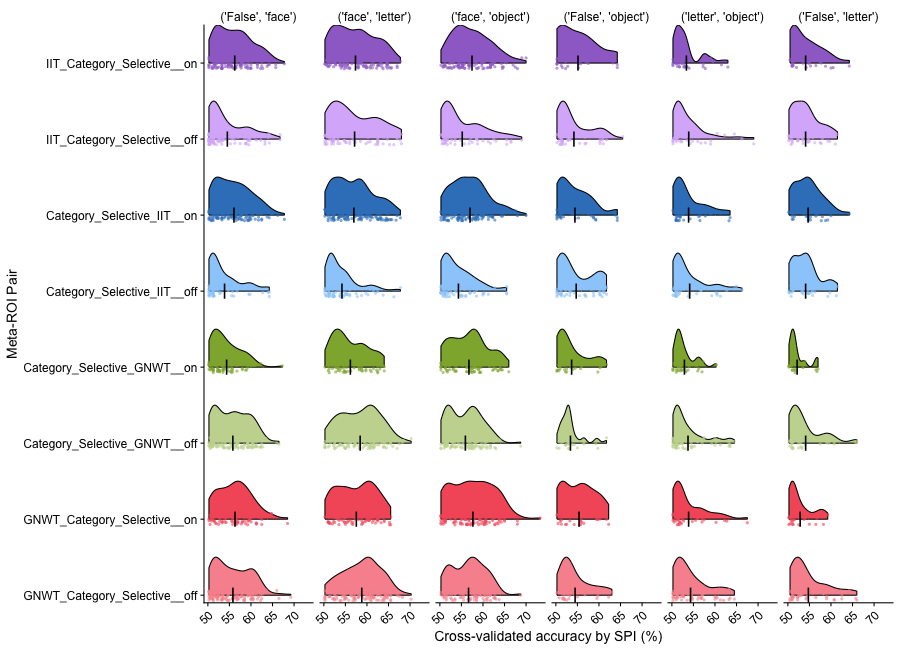

In [319]:
%%R -i stimulus_type_classification_res -w 900 -h 650 

stimulus_type_classification_res %>% 
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy, 
           stimulus_presentation = factor(stimulus_presentation, levels = c("on", "off"))) %>%
    rowwise() %>%
    mutate(sp_and_roi = paste0(meta_ROI_pair, "__", stimulus_presentation)) %>%
    mutate(sp_and_roi = factor(sp_and_roi, levels = rev(c("IIT_Category_Selective__on",
                                                        "IIT_Category_Selective__off",
                                                        "Category_Selective_IIT__on",
                                                        "Category_Selective_IIT__off",
                                                        "Category_Selective_GNWT__on",
                                                        "Category_Selective_GNWT__off",
                                                        "GNWT_Category_Selective__on",
                                                        "GNWT_Category_Selective__off"))),
                stimulus_combo = fct_reorder(stimulus_combo, accuracy, .fun=mean)) %>%
    ggplot(data=., mapping=aes(x=sp_and_roi, y=accuracy, fill=sp_and_roi)) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=1)  +
    geom_point(aes(color = sp_and_roi), position = position_jitter(width = 0.075, height=0),
                            size = 1.5, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    scale_color_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    scale_fill_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    facet_grid(. ~ stimulus_combo, scales="free") + 
    theme(legend.position = "bottom") +
    scale_x_discrete(expand = c(0, 0))+
    xlab("Meta-ROI Pair") +
    ylab("Cross-validated accuracy by SPI (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
          legend.position="none",
          axis.text.x = element_text(angle=45, hjust=1)) +
    coord_flip()

# ggsave('plots/Stimulus_wise_classification_performance_by_meta_ROI_pair.svg', width=10, height=6, units='in', dpi=300)

In [340]:
relevance_type_classification_res.head()

,SPI,meta_ROI_from,meta_ROI_to,stimulus_presentation,comparison,accuracy,meta_ROI_pair
0,cov_EmpiricalCovariance,GNWT,Category_Selective,on,Relevant non-target vs. Irrelevant,0.510625,GNWT_Category_Selective
1,cov_GraphicalLasso,GNWT,Category_Selective,on,Relevant non-target vs. Irrelevant,0.496250,GNWT_Category_Selective
2,cov_GraphicalLassoCV,GNWT,Category_Selective,on,Relevant non-target vs. Irrelevant,0.516875,GNWT_Category_Selective
3,cov_LedoitWolf,GNWT,Category_Selective,on,Relevant non-target vs. Irrelevant,0.507500,GNWT_Category_Selective
4,cov_OAS,GNWT,Category_Selective,on,Relevant non-target vs. Irrelevant,0.507500,GNWT_Category_Selective


In [345]:
%%R -i relevance_type_classification_res -w 900 -h 650 

relevance_type_classification_res %>% 
    filter(accuracy > 0.5) %>%
    mutate(accuracy = 100*accuracy, 
           stimulus_presentation = factor(stimulus_presentation, levels = c("on", "off"))) %>%
    rowwise() %>%
    mutate(sp_and_roi = paste0(meta_ROI_pair, "__", stimulus_presentation)) %>%
    mutate(sp_and_roi = factor(sp_and_roi, levels = rev(c("IIT_Category_Selective__on",
                                                        "IIT_Category_Selective__off",
                                                        "Category_Selective_IIT__on",
                                                        "Category_Selective_IIT__off",
                                                        "Category_Selective_GNWT__on",
                                                        "Category_Selective_GNWT__off",
                                                        "GNWT_Category_Selective__on",
                                                        "GNWT_Category_Selective__off"))),
                stimulus_combo = fct_reorder(stimulus_combo, accuracy, .fun=mean)) %>%
    ggplot(data=., mapping=aes(x=sp_and_roi, y=accuracy, fill=sp_and_roi)) +
    geom_violinhalf(scale="width", color="black", position = position_dodge(width = 1), width=1)  +
    geom_point(aes(color = sp_and_roi), position = position_jitter(width = 0.075, height=0),
                            size = 1.5, alpha=0.6, stroke=0) +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.2, linewidth=0.3, 
            show.legend=FALSE, position = position_dodge(width=1.4)) +
    scale_color_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    scale_fill_manual(values=c("IIT_Category_Selective__on" = "#9F70CE",
                                "IIT_Category_Selective__off" = "#D9B7FA",
                                "Category_Selective_IIT__on" = "#3982C4",
                                "Category_Selective_IIT__off" = "#9BCEFB",
                                "Category_Selective_GNWT__on" = "#8EB03A",
                                "Category_Selective_GNWT__off" = "#C6D79D",
                                "GNWT_Category_Selective__on" = "#f55c69",
                                "GNWT_Category_Selective__off" = "#f8949c")) +
    theme(legend.position = "bottom") +
    scale_x_discrete(expand = c(0, 0))+
    xlab("Meta-ROI Pair") +
    ylab("Cross-validated accuracy by SPI (%)") +
    labs(fill="Stimulus Presentation", color="Stimulus Presentation") +
    theme(strip.background = element_blank(),
          legend.position="none",
          axis.text.x = element_text(angle=45, hjust=1)) +
    coord_flip()

ggsave('plots/Relevance_type_classification_performance_by_meta_ROI_pair.svg', width=4.5, height=6, units='in', dpi=300)

## For each meta-ROI pair, what is the maximum accuracy across contexts?

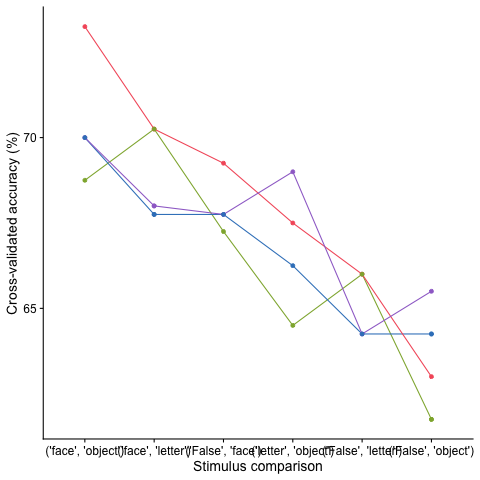

In [320]:
%%R -i stimulus_type_classification_res

stimulus_type_classification_res %>% 
    group_by(meta_ROI_pair, stimulus_combo) %>% 
    filter(accuracy==max(accuracy,na.rm=T)) %>%
    ungroup() %>%
    mutate(accuracy=100*accuracy, 
            stimulus_combo = fct_reorder(stimulus_combo, accuracy, .fun=max, .desc=TRUE)) %>%
    ggplot(data=., mapping=aes(x=stimulus_combo, y=accuracy, color=meta_ROI_pair, group=meta_ROI_pair)) +
    geom_line() +
    geom_point() + 
    xlab("Stimulus comparison") +
    theme(legend.position="none") +
    ylab("Cross-validated accuracy (%)") +
    scale_color_manual(values=c("IIT_Category_Selective" = "#9F70CE",
                                "Category_Selective_IIT" = "#3982C4",
                                "Category_Selective_GNWT" = "#8EB03A",
                                "GNWT_Category_Selective" = "#f55c69"))

# ggsave('plots/Max_performance_for_each_stim_combo_by_meta_ROI_pair.svg', width=5.5, height=3.25, units='in', dpi=300)

## What does the distribution of each stimulus type look like for the top SPI per meta-ROI pair?

In [368]:
%%R -i stimulus_type_classification_res,all_pyspi_res -o pyspi_res_top_SPIs,top_SPI

top_SPI <- stimulus_type_classification_res %>%
    filter(stimulus_combo=="('face', 'object')") %>% 
    ungroup() %>% 
    group_by(meta_ROI_pair) %>%
    filter(accuracy == max(accuracy)) %>% 
    dplyr::select(meta_ROI_to, meta_ROI_from, SPI, stimulus_presentation, relevance_type) %>% 
    dplyr::rename("stimulus" = "stimulus_presentation")

pyspi_res_top_SPIs <- all_pyspi_res %>% 
    semi_join(., top_SPI) %>% 
    filter(stimulus_type %in% c("face", "object"))

/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Adding missing grouping variables: `meta_ROI_pair`
Joining with `by = join_by(SPI, meta_ROI_from, meta_ROI_to, relevance_type,
stimulus)`


In [370]:
%%R -i pyspi_res_top_SPIs

pyspi_res_top_SPIs %>% 
    mutate(meta_ROI_pair = glue("{meta_ROI_from}_{meta_ROI_to}")) %>%
    ungroup() %>%
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("IIT_Category_Selective", 
                                                            "Category_Selective_IIT",
                                                            "Category_Selective_GNWT",
                                                            "GNWT_Category_Selective"))) %>% 
    ggplot(data=., mapping=aes(x=stimulus_type, y=value)) +
    geom_violin(aes(fill=stimulus_type)) + 
    geom_point(aes(group=subject_ID), alpha=0.6, size=0.85) +
    geom_line(aes(group=subject_ID), alpha=0.2, linewidth=0.5) +
    xlab("Stimulus presentation") +
    ylab("SPI Value") +
    facet_grid(meta_ROI_pair ~ ., scales="free", switch="both") +
    scale_x_discrete(expand=c(0,0)) +
    theme(strip.placement="outside", 
            strip.background=element_blank(),
            legend.position="none")

ggsave('plots/Face_vs_Object_top_SPI_by_region_pair.svg', width=3, height=4.5, units='in', dpi=300)

In addition: Warning messages:
1: Removed 2 rows containing non-finite outside the scale range
(`stat_ydensity()`). 
2: Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`). 


## For each meta-ROI pair, what are the top 10 SPIs across contexts? Is there any overlap?

In [5]:
%%R -i stimulus_type_classification_res -o max_performance_by_SPI,top_10_SPIs_by_meta_ROI,top_10_SPIs_by_meta_ROI_all_ROIs -w 1200

max_performance_by_SPI <- stimulus_type_classification_res %>% 
    dplyr::select(meta_ROI_pair, SPI, accuracy) %>%
    group_by(meta_ROI_pair, SPI) %>% 
    filter(accuracy == max(accuracy))  %>% 
    distinct() %>%
    group_by(meta_ROI_pair) %>%
    mutate(accuracy_neg = -1*accuracy) %>%
    mutate(accuracy_rank = rank(accuracy_neg, ties.method="min")) %>%
    ungroup() 
    
top_10_SPIs_by_meta_ROI <- max_performance_by_SPI%>% 
    filter(accuracy_rank<=10) %>% 
    dplyr::select(meta_ROI_pair, SPI) %>% 
    dplyr::rename("meta_ROI_pair_with_top10" = "meta_ROI_pair")

top_10_SPIs_by_meta_ROI_all_ROIs <- top_10_SPIs_by_meta_ROI %>%
    left_join(., max_performance_by_SPI)

top_10_SPIs_by_meta_ROI_all_ROIs <- top_10_SPIs_by_meta_ROI_all_ROIs %>% mutate(accuracy=100*accuracy)
lower_lim <- min(top_10_SPIs_by_meta_ROI_all_ROIs$accuracy)
upper_lim <- max(top_10_SPIs_by_meta_ROI_all_ROIs$accuracy)

plot_heatmap_for_meta_ROI_pair_with_top10 <- function(this_ROI_pair, max_fill_color) {
    this_df <- top_10_SPIs_by_meta_ROI_all_ROIs %>% 
        filter(meta_ROI_pair_with_top10==this_ROI_pair) %>% 
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("IIT_Category_Selective", 
                                                                "Category_Selective_IIT",
                                                                "Category_Selective_GNWT",
                                                                "GNWT_Category_Selective"))) %>% 
        mutate(SPI = fct_reorder(SPI, accuracy, .fun=mean, .desc=F))

    this_df %>% 
        ggplot(data=., mapping=aes(x=meta_ROI_pair, y=SPI, fill=accuracy)) +
        geom_tile() +
        facet_grid(meta_ROI_pair_with_top10 ~ ., scales="free", switch="both") +
        scale_fill_gradient(low="white", high=max_fill_color, limits=c(lower_lim, upper_lim)) +
        scale_x_discrete(expand=c(0,0)) +
        scale_y_discrete(expand=c(0,0)) +
        theme(strip.placement="outside",
            strip.background = element_blank())
}

IIT_Category_Selective_top10_plot <- plot_heatmap_for_meta_ROI_pair_with_top10(this_ROI_pair="IIT_Category_Selective",
                                                                                max_fill_color="#63269f")
Category_Selective_IIT_top10_plot <- plot_heatmap_for_meta_ROI_pair_with_top10(this_ROI_pair="Category_Selective_IIT",
                                                                                max_fill_color="#0f5a9e")
Category_Selective_GNWT_top10_plot <- plot_heatmap_for_meta_ROI_pair_with_top10(this_ROI_pair="Category_Selective_GNWT",
                                                                                max_fill_color="#557600")
GNWT_Category_Selective_top10_plot <- plot_heatmap_for_meta_ROI_pair_with_top10(this_ROI_pair="GNWT_Category_Selective",
                                                                                max_fill_color="#c90c1c")

wrap_plots(list(IIT_Category_Selective_top10_plot, 
                Category_Selective_IIT_top10_plot, 
                Category_Selective_GNWT_top10_plot, 
                GNWT_Category_Selective_top10_plot), axes='collect', ncol=1) +
  plot_layout(axis_titles = "collect") 

ggsave('plots/Top_10_SPIs_for_stimulus_combo_by_ROI_pair_across_ROI_pairs.svg', width=8, height=7, units='in', dpi=300)

Joining with `by = join_by(SPI)`


In addition: Warning message:
In left_join(., max_performance_by_SPI) :
  Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 79 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.


## What if we take the SPIs with accuracy > 65% and compare across A) ROI pairs and B) stimulus types?

In [6]:
%%R -i stimulus_type_classification_res -o SPIs_greater_than_65_by_meta_ROI_pair,IIT_Category_Selective_list,Category_Selective_IIT_list,Category_Selective_GNWT_list,GNWT_Category_Selective_list

# First, compare across ROI pairs
SPIs_greater_than_65_by_meta_ROI_pair <- stimulus_type_classification_res %>% 
    mutate(accuracy = 100*accuracy) %>%
    dplyr::select(meta_ROI_pair, SPI, accuracy) %>%
    group_by(meta_ROI_pair, SPI) %>% 
    filter(accuracy == max(accuracy)) %>% 
    rowwise() %>%
    filter(accuracy > 65) %>% 
    distinct() %>%
    mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = c("IIT_Category_Selective", 
                                                                "Category_Selective_IIT",
                                                                "Category_Selective_GNWT",
                                                                "GNWT_Category_Selective")))

SPIs_greater_than_65_by_meta_ROI_pair_split <- split(SPIs_greater_than_65_by_meta_ROI_pair$SPI, SPIs_greater_than_65_by_meta_ROI_pair$meta_ROI_pair)
IIT_Category_Selective_list <- SPIs_greater_than_65_by_meta_ROI_pair_split[[1]]
Category_Selective_IIT_list <- SPIs_greater_than_65_by_meta_ROI_pair_split[[2]]
Category_Selective_GNWT_list <- SPIs_greater_than_65_by_meta_ROI_pair_split[[3]]
GNWT_Category_Selective_list <- SPIs_greater_than_65_by_meta_ROI_pair_split[[4]]

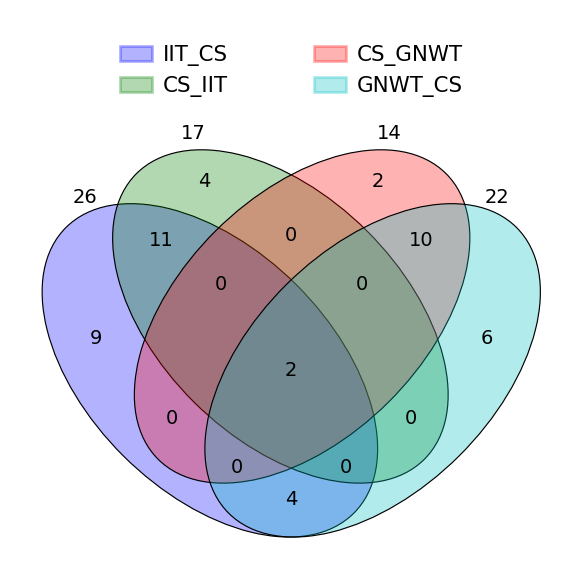

In [46]:
# Venn diagram for meta-ROI pairs
my_sets = {
    'IIT_CS': set(IIT_Category_Selective_list),
        'CS_IIT': set(Category_Selective_IIT_list),
        'CS_GNWT': set(Category_Selective_GNWT_list),
        'GNWT_CS': set(GNWT_Category_Selective_list)
}

venny4py(sets = my_sets, out="plots/", ext="svg", dpi=300)

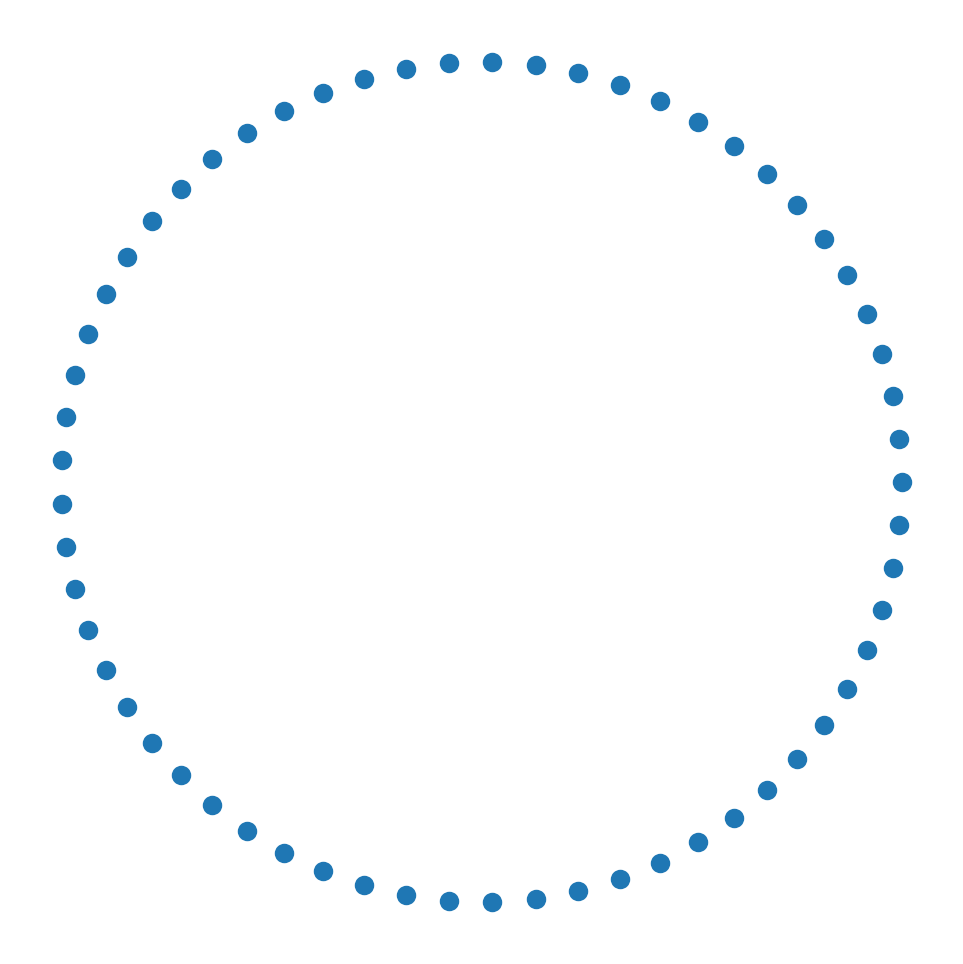

In [95]:
import numpy as np
import matplotlib.pyplot as plt

# Number of points
num_points = 61

# Generate evenly spaced angles between 0 and 2*pi
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False)

# Calculate the x and y coordinates
x = np.cos(angles)
y = np.sin(angles)

# Plot the points
plt.figure(figsize=(6,6))
plt.scatter(x, y)
plt.gca().set_aspect('equal', adjustable='box')

# Remove axis lines, labels, and ticks
plt.axis('off')

# Save to SVG
plt.savefig('plots/points_on_circle.svg')

In [37]:
all_subjects = pd.read_table("/Users/abry4213/data/Cogitate_MEG_challenge/subject_list.txt", header=None)
all_subjects.columns = ['subject_ID']
filtered_subjects = pd.read_table("/Users/abry4213/data/Cogitate_MEG_challenge/subject_list_filtered.txt", header=None)
filtered_subjects.columns = ['subject_ID']

# Find all_subjects not in filtered_subjects
all_subjects[~all_subjects.subject_ID.isin(filtered_subjects.subject_ID)]

,subject_ID
13,CA136
19,CA167


### Plot the overlap in SPI feature types by A) meta-ROI pair and B) stimulus type

In [8]:
pyspi_SPI_info = pd.read_csv("../feature_extraction/pyspi_SPI_info.csv")

,meta_ROI_pair,SPI,accuracy,Directionality,Literature_category,Module
0,GNWT_Category_Selective,dtf_multitaper_mean_fs-1_fmin-0_fmax-0-25,65.25,Directed,spectral,M06
1,GNWT_Category_Selective,dtf_multitaper_max_fs-1_fmin-0_fmax-0-5,68.00,Directed,spectral,M06
2,GNWT_Category_Selective,dtf_multitaper_max_fs-1_fmin-0_fmax-0-25,65.50,Directed,spectral,M06
3,IIT_Category_Selective,dtf_multitaper_max_fs-1_fmin-0_fmax-0-25,68.00,Directed,spectral,M06
4,GNWT_Category_Selective,pdcoh_multitaper_mean_fs-1_fmin-0_fmax-0-25,65.25,Directed,spectral,M06


In [21]:
%%R -i SPIs_greater_than_65_by_meta_ROI_pair,pyspi_SPI_info 

# A) By meta-ROI pair
SPIs_greater_than_65_by_meta_ROI_pair %>% 
    left_join(., pyspi_SPI_info) %>% 
        mutate(meta_ROI_pair = factor(meta_ROI_pair, levels = rev(c("IIT_Category_Selective", 
                                                                "Category_Selective_IIT",
                                                                "Category_Selective_GNWT",
                                                                "GNWT_Category_Selective")))) %>%
    ggplot(data=., mapping=aes(x=meta_ROI_pair, fill=Literature_category)) +
    geom_bar() +
    coord_flip() +
    xlab("Meta-ROI Pair") +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 65%") +
    theme(legend.position = "bottom")

ggsave('plots/Meta_ROI_pair_top_SPI_categories.svg', width=6, height=3.5, units='in', dpi=300)

Joining with `by = join_by(SPI)`


In [32]:
stimulus_type_classification_res.SPI.unique()

array(['cov_EmpiricalCovariance', 'cov_GraphicalLasso',
       'cov_GraphicalLassoCV', 'cov_LedoitWolf', 'cov_OAS',
       'cov_ShrunkCovariance', 'cov-sq_EmpiricalCovariance',
       'cov-sq_GraphicalLasso', 'cov-sq_LedoitWolf', 'cov-sq_OAS',
       'cov-sq_ShrunkCovariance', 'prec_EmpiricalCovariance',
       'prec_GraphicalLasso', 'prec_LedoitWolf', 'prec_OAS',
       'prec_ShrunkCovariance', 'prec-sq_EmpiricalCovariance',
       'prec-sq_GraphicalLasso', 'prec-sq_LedoitWolf', 'prec-sq_OAS',
       'prec-sq_ShrunkCovariance', 'spearmanr-sq', 'spearmanr',
       'kendalltau-sq', 'kendalltau', 'xcorr_max_sig-True',
       'xcorr-sq_max_sig-True', 'xcorr_mean_sig-True',
       'xcorr-sq_mean_sig-True', 'xcorr_mean_sig-False',
       'xcorr-sq_mean_sig-False', 'pdist_euclidean', 'pdist_cityblock',
       'pdist_cosine', 'pdist_chebyshev', 'pdist_canberra',
       'pdist_braycurtis', 'dcorr', 'dcorr_biased', 'hsic', 'hsic_biased',
       'bary_euclidean_max', 'bary-sq_euclidean_mean',
  

In [29]:
%%R -i stimulus_type_classification_res,pyspi_SPI_info -o SPIs_greater_than_65_by_stimulus_combo

# First, compare across ROI pairs
SPIs_greater_than_65_by_stimulus_combo <- stimulus_type_classification_res %>% 
    mutate(accuracy = 100*accuracy) %>%
    dplyr::select(stimulus_combo, SPI, accuracy) %>%
    group_by(stimulus_combo, SPI) %>% 
    filter(accuracy == max(accuracy)) %>% 
    rowwise() %>%
    filter(accuracy > 65) %>% 
    distinct() %>% 
    mutate(stimulus_combo = factor(stimulus_combo, levels = rev(c( "('face', 'letter')", "('face', 'object')",  
                                                             "('False', 'face')",  "('False', 'letter')",
                                                              "('letter', 'object')", "('False', 'object')"))))


# A) By meta-ROI pair
SPIs_greater_than_65_by_stimulus_combo %>% 
    left_join(., pyspi_SPI_info) %>%
    ggplot(data=., mapping=aes(x=stimulus_combo, fill=Literature_category)) +
    geom_bar() +
    coord_flip() +
    xlab("Meta-ROI Pair") +
    scale_y_continuous(expand=c(0,0)) +
    scale_x_discrete(expand=c(0,0)) +
    ylab("Count of SPIs with Accuracy >= 65%") +
    theme(legend.position = "bottom")

ggsave('plots/Stimulus_combo_top_SPI_categories.svg', width=6, height=3.5, units='in', dpi=300)

Joining with `by = join_by(SPI)`


## How variable is each SPI across participants even within a given context?

In [365]:
SPI = "pec"
this_SPI_data = all_pyspi_res.query("SPI==@SPI & stimulus=='on' & relevance_type=='Relevant non-target'")